In [2]:
import matplotlib.pylab as plt

import tensorflow as tf

In [3]:
import tensorflow_hub as hub

from tensorflow.keras import layers

In [4]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [5]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

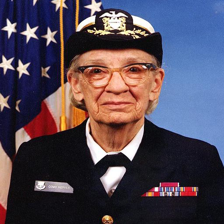

In [6]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [8]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 5s 5s/step


(1, 1001)

In [9]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

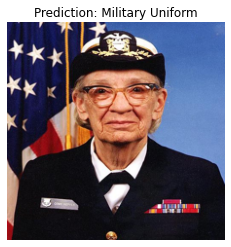

In [11]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [12]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [13]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [14]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [15]:
result_batch = classifier.predict(image_batch)
result_batch.shape

1/1 [==============================] - 1s 550ms/step


(32, 1001)

In [16]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['velvet', 'tub', 'buckeye', 'picket fence', 'banana', 'spindle',
       'maze', 'daisy', 'torch', 'daisy', 'pot', 'sea urchin',
       'coral fungus', 'daisy', 'sea urchin', 'bee', 'cock', 'porcupine',
       'daisy', 'feather boa', 'mushroom', "yellow lady's slipper",
       'park bench', 'cup', 'cardoon', 'cardoon', 'plastic bag', 'daisy',
       'plow', 'rapeseed', 'daisy', 'daisy'], dtype='<U30')

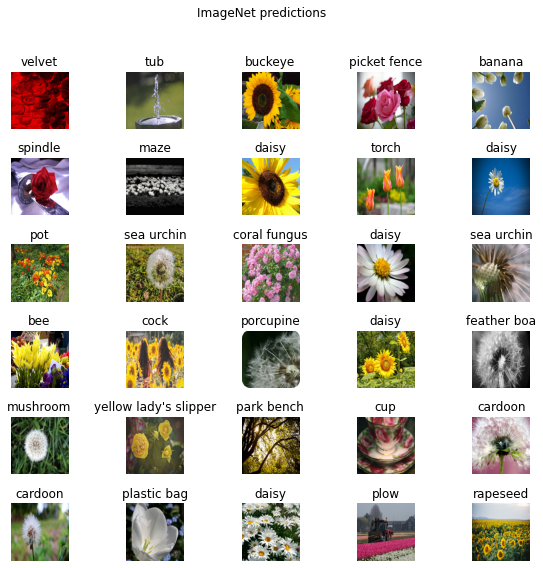

In [17]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [18]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [19]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [20]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [21]:
feature_extractor_layer.trainable = False

In [22]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
predictions = model(image_batch)

In [24]:
predictions.shape

TensorShape([32, 5])

In [25]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [26]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [27]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/2


C:\Users\nengcham\AppData\Local\Temp\ipykernel_10512\645089771.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(image_data, epochs=2,


115/115 [==============================] - 15s 88ms/step - loss: 0.3158 - acc: 0.8125
Epoch 2/2
115/115 [==============================] - 9s 80ms/step - loss: 0.4595 - acc: 0.8438


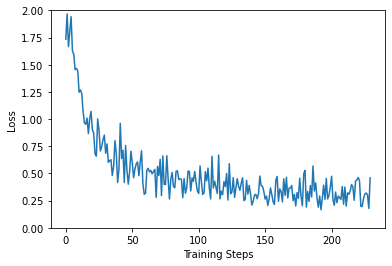

In [28]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

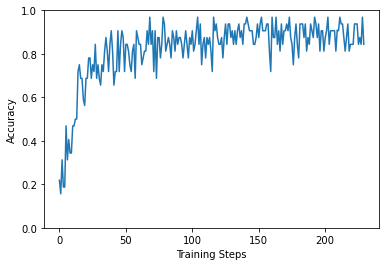

In [29]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [30]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [31]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

1/1 [==============================] - 0s 493ms/step


In [32]:
label_id = np.argmax(label_batch, axis=-1)

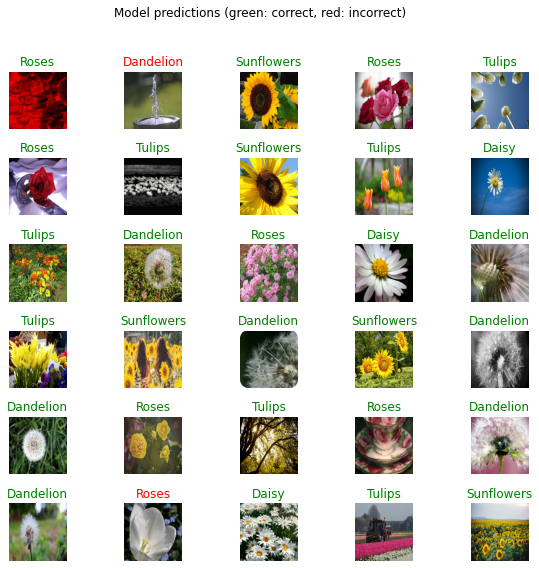

In [33]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [34]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1656491884\assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1656491884\assets


'/tmp/saved_models/1656491884'

In [35]:
reloaded = tf.keras.models.load_model(export_path)

In [36]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 0s 481ms/step


In [37]:
abs(reloaded_result_batch - result_batch).max()

0.0